In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from pandas.util.testing import assert_frame_equal
import pandas.testing
import datetime as dt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from tempfile import mkdtemp
from shutil import rmtree

import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

# from zipline.assets.assets import Equity, Future


In [2]:
# Read data as at submission 2
spy_data = pd.read_csv('./stockdata/SPY_sub2.csv')
spy_data.head()

,Adj Close,Volume,Log Returns,MACD_Hist,RSI,Day,Target
0,2.892223,18.432569,0.042601,1.374663,3.730973,2,0
1,2.685900,18.821887,0.024492,1.374663,3.730973,5,0
2,2.561067,19.056630,0.033005,1.374663,3.730973,6,1
3,2.721693,18.470201,0.053923,1.374663,3.730973,7,1
4,2.915566,18.659287,0.058843,1.374663,3.730973,8,0


In [3]:
spy_data.rename(columns={"Adj Close": "Adj_Close", "Log Returns": "Log_Returns"}, inplace=True)

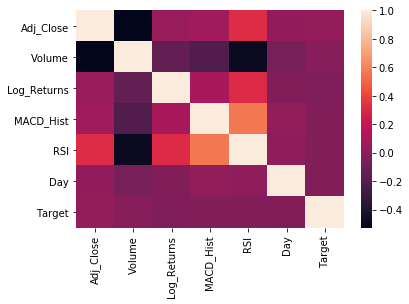

In [4]:
# Check correlation with heatmap graph
corr = spy_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [5]:
# Split dataset in features (X) and labels (y)
X = spy_data.drop(columns = ['Target'])
y = np.ravel(spy_data['Target'])

In [6]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, 
                                                    random_state=42)

In [7]:
print('X_train shape: ',X_train.shape) 
print('X_test shape: ',X_test.shape)
print('')
print('y_train shape: ',y_train.shape) 
print('y_test shape: ',y_test.shape)

X_train shape:  (815, 6)
X_test shape:  (350, 6)

y_train shape:  (815,)
y_test shape:  (350,)


In [8]:
# Create Neural Network Model

def create_model():
    model = Sequential()
    model.add(Dense(144, input_dim=6, activation='relu'))
    model.add(Dense(72, activation='relu'))
    model.add(Dense(36, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
# Create pipeline and gridsearchcv

cachedir = mkdtemp()

nn_pipe = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA()),
                    ('classifier', KerasClassifier(build_fn=create_model, 
                                                   epochs=100, verbose=0))], memory=cachedir)

param_grid = {"pca__n_components":[2, 3, 4, 5, 6],
              "classifier__batch_size": [20, 32]}
gs = GridSearchCV(nn_pipe, param_grid, cv=5, n_jobs=2, scoring ='accuracy', verbose=1)
gs.fit(X_train, y_train)

rmtree(cachedir)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   46.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  1.0min finished


In [10]:
gs.best_params_

{'classifier__batch_size': 32, 'pca__n_components': 6}

In [11]:
gs.score(X_train, y_train)

0.9631901840490797

In [12]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, gs.predict_proba(X_test)[:,1])

In [13]:
# calculate AUC
roc_auc = roc_auc_score(y_test, gs.predict(X_test))
print('AUC: %.3f' % roc_auc)

AUC: 0.558


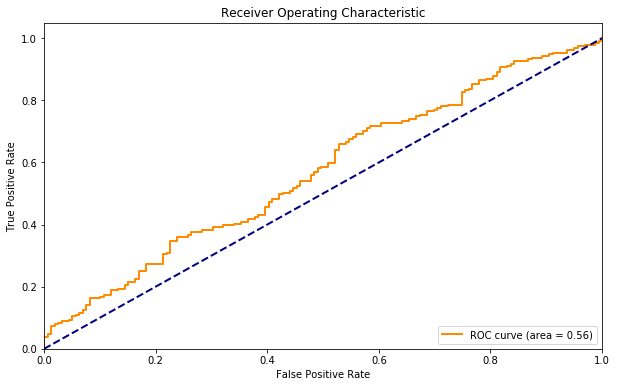

In [14]:
# Plot ROC Curve
plt.figure(figsize=[10,6])
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Performance metrics
y_pred = gs.predict(X_test)

# Confusion Matrix
print('Confusion Matrix:')
print('------------------')
print(confusion_matrix(y_test,y_pred))

Confusion Matrix:
------------------
[[ 76  83]
 [ 69 122]]


In [16]:
# Precision, Recall, F1-Score, Accuracy, and AUC. 
print('Classification Report:')
print('--------------------------------------------------------')
print(classification_report(y_test,y_pred))

Classification Report:
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       159
           1       0.60      0.64      0.62       191

    accuracy                           0.57       350
   macro avg       0.56      0.56      0.56       350
weighted avg       0.56      0.57      0.56       350



In [17]:
# Fund Factsheet
# Fectch daily return for SPY
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
spy_px = pd.read_csv('./stockdata/SPY.csv', usecols=['Date','Adj Close'], 
                  index_col=['Date'], parse_dates=['Date'], 
                  date_parser=dateparse)

spy_rets = spy_px[['Adj Close']].pct_change().dropna()
spy_rets = pd.Series(spy_rets['Adj Close'])
spy_rets[:5]

Date
2015-01-05   -0.018060
2015-01-06   -0.009419
2015-01-07    0.012461
2015-01-08    0.017745
2015-01-09   -0.008014
Name: Adj Close, dtype: float64

Start date,2015-01-05
End date,2019-12-30
Total months,59
,Backtest
Annual return,11.6%
Cumulative returns,72.5%
Annual volatility,13.4%
Sharpe ratio,0.88
Calmar ratio,0.60
Stability,0.93
Max drawdown,-19.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.35,2018-09-20,2018-12-24,2019-04-12,147
1,13.02,2015-07-20,2016-02-11,2016-04-18,196
2,10.10,2018-01-26,2018-02-08,2018-08-06,137
3,6.62,2019-05-03,2019-06-03,2019-06-20,35
4,6.02,2019-07-26,2019-08-05,2019-10-25,66


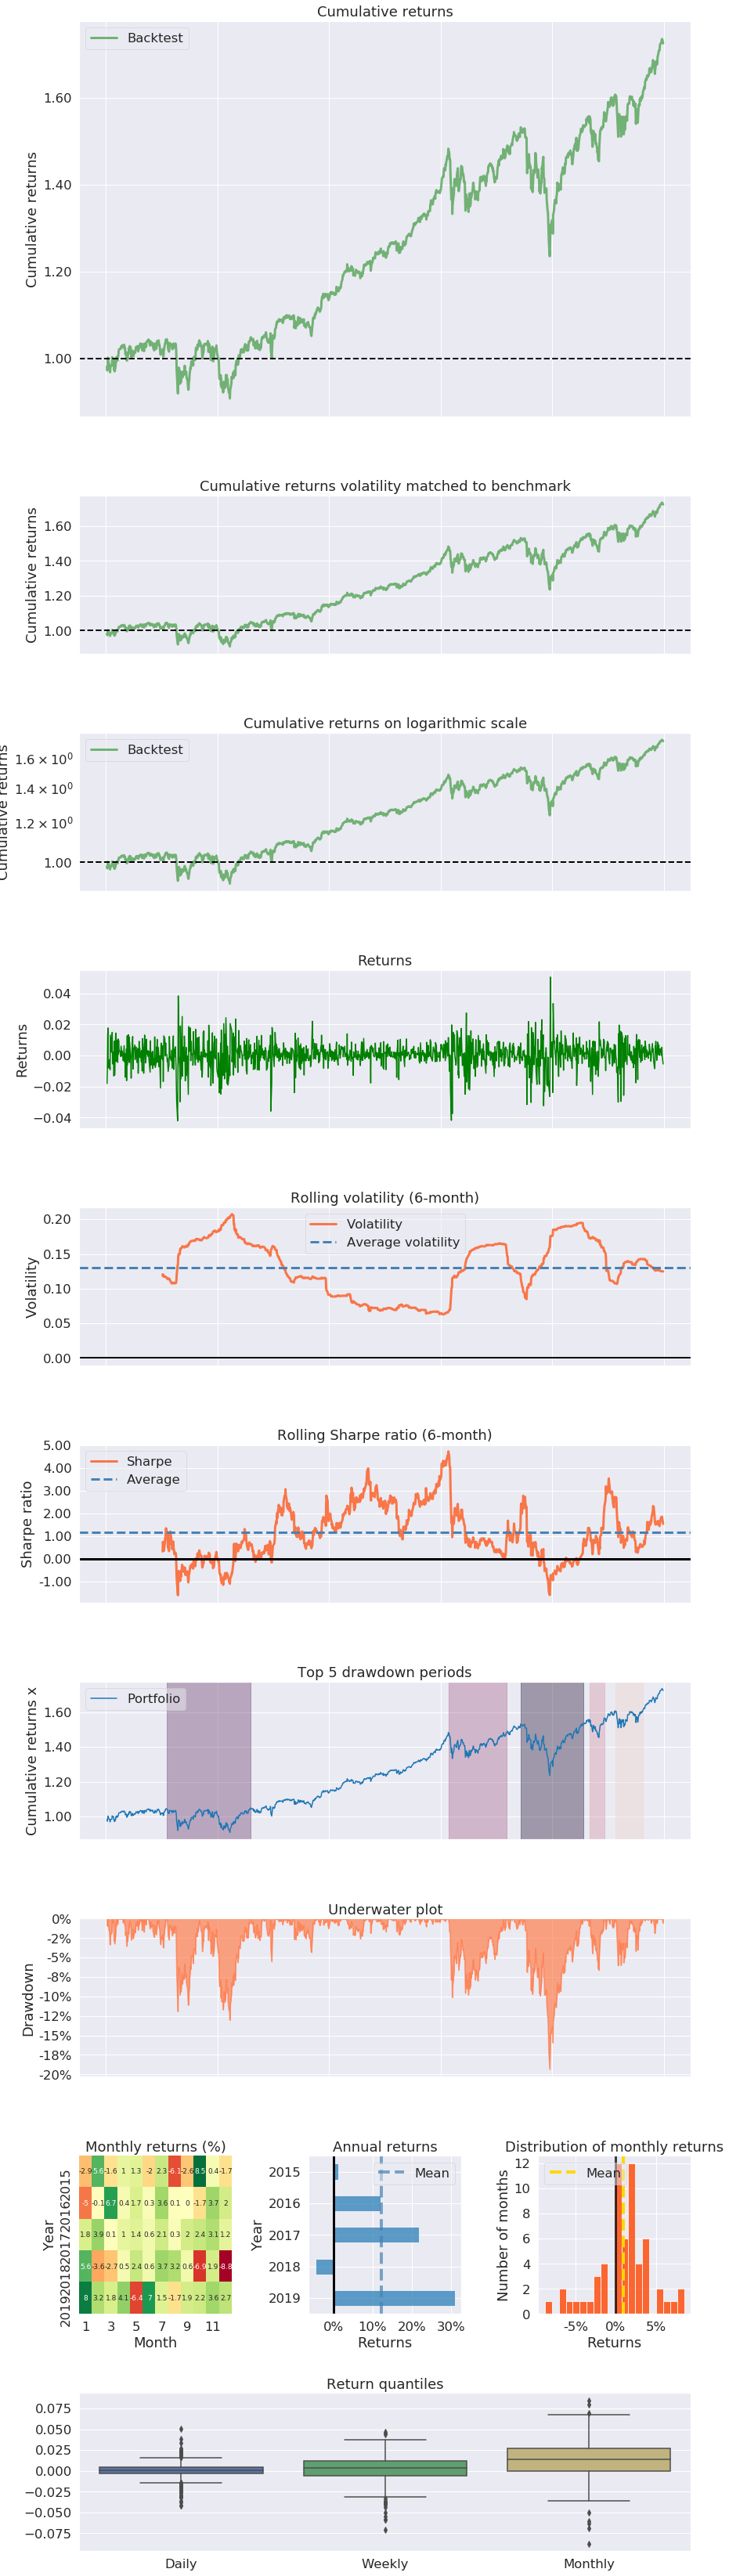

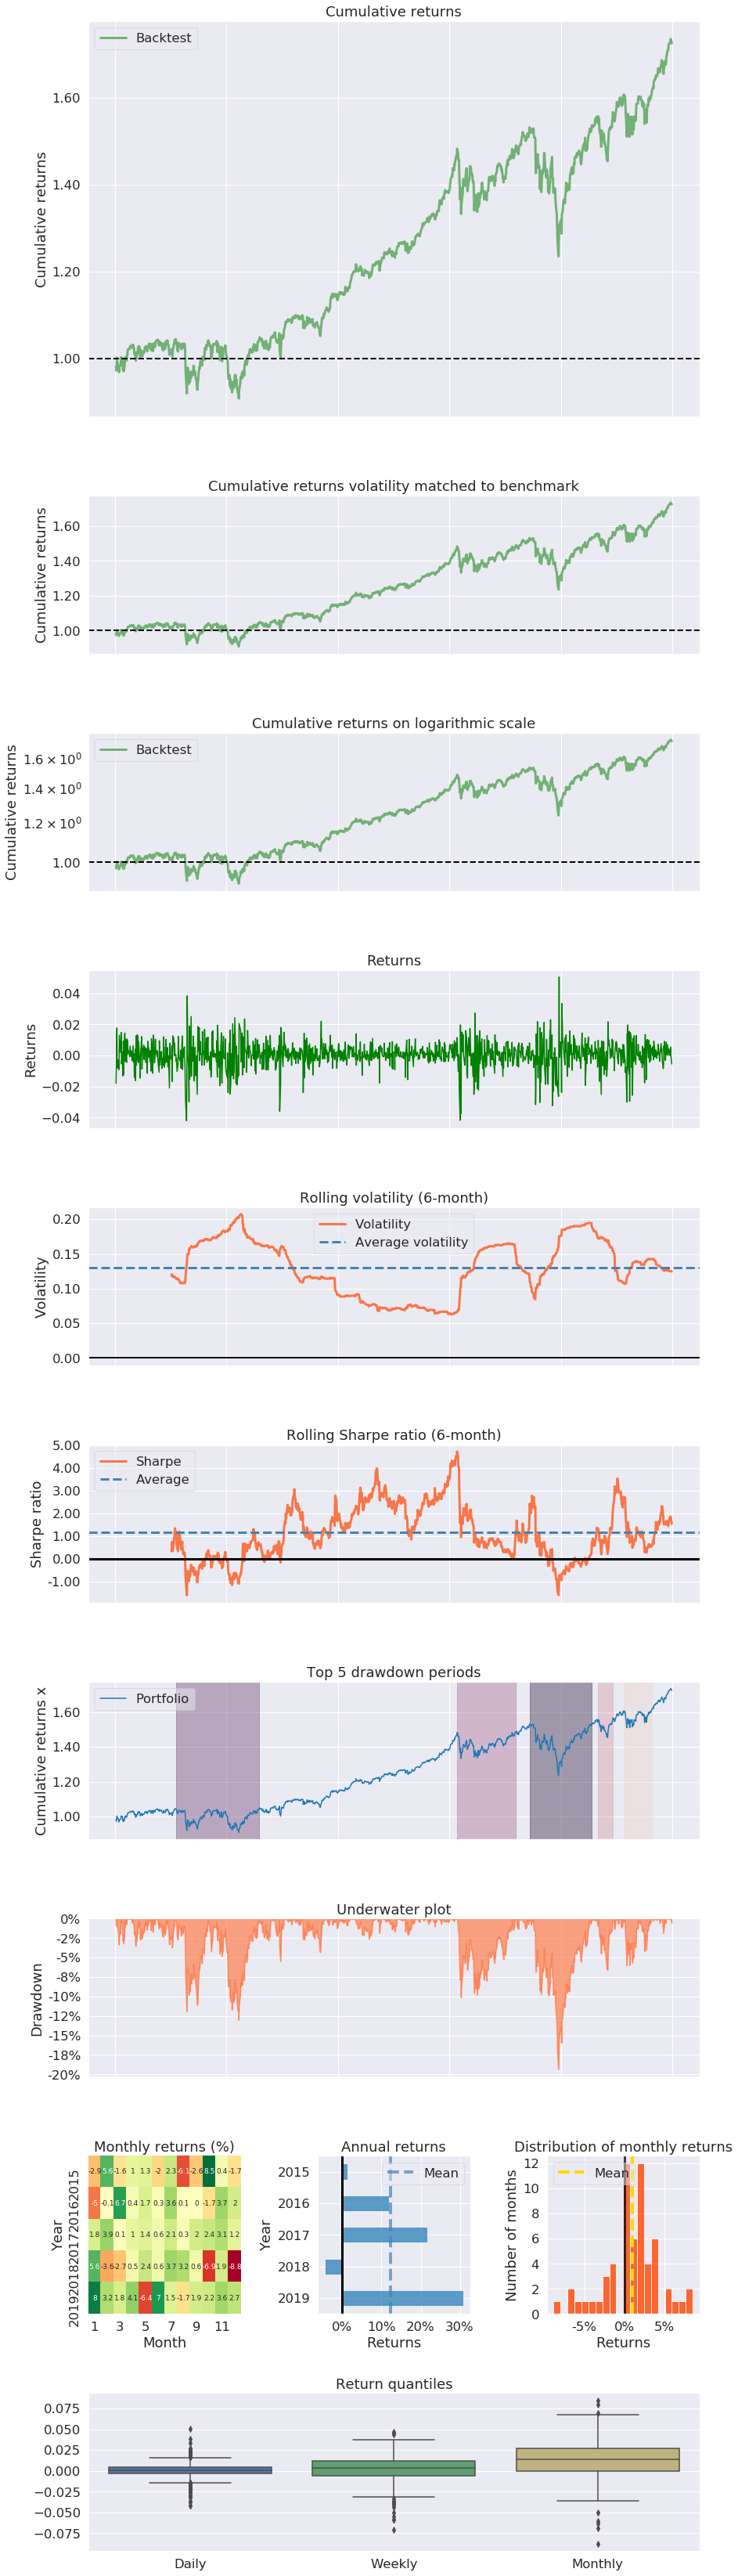

In [18]:
pf.create_returns_tear_sheet(spy_rets, return_fig=True)

In [21]:
cum_rets = pd.DataFrame(spy_rets)
cum_rets = cum_rets[['Adj Close']].cumsum()
cum_rets.tail()

,Adj Close
Date,
2019-12-23,0.590649
2019-12-24,0.590681
2019-12-26,0.596004
2019-12-27,0.595756
2019-12-30,0.590243


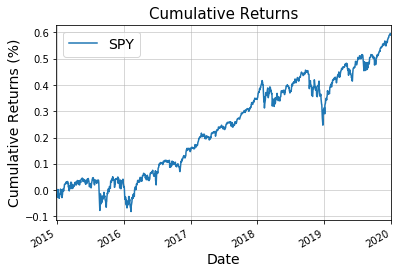

In [22]:
# Plotting Cumulative Returns
fig, ax = plt.subplots(figsize=(6,4))

cum_rets['Adj Close'].plot(label='SPY')
plt.xlim(['2014-12-31', '2020-1-1'])
plt.legend(loc=2,prop={'size':14})
ax.grid(linewidth=0.5)
ax.set_xlabel("Date",{'fontsize':14})
ax.set_ylabel("Cumulative Returns (%)",{'fontsize':14})
ax.set_title("Cumulative Returns",{'fontsize':15})
plt.show()